#                                        Continuous Integration 

## 1. Automatic Fault Detection

The goal is to find, in a revision, which Change-List (CL) caused a regression, in a short amount of time.

<img src="dummy_data/CL.png" alt="Drawing" style="width: 500px;"/>

Test are executed periodically, for example, every $N$  $CL$. In this case, at $CL_{G}$ all tests are passing (*Green*) and at $CL_{R}$ some test are failing (*Red*). Hence, there has to be some **Culprit CL** in the range $[CL_{G}, CL_{R}]$, that caused a regression.

A possible solution to finding the culprit is conducting a search over the range $[CL_{G}, CL_{R}]$, an example of it is doing *binary-search*. However, to obtain results faster, we can implement machine learning models that tell us where to look first and which **CL's** are more likely to be the ones that caused a regression.

This way, we are able to notify the developers responsable for those changes and catch/correct them early on.

## 2. Optimizing Regression Testing

Above, we show how it is possible to prioritize different CL's to avoid testing "unnecessary" or "non-revealing" CL's. However, if a CL is very suspicious, but tests take 8+ hours to discover if the change is defective or not, it is not of much use. 

So in parallel to Defect Prediction, the way Regression Testing is done can be optimized by applying these techniques:

- **Test Case Minimisation**
- **Test Case Selection**
- **Test Case Prioritization**

This way, we propose to reduce the lag time between a commit and project status feedback by a significant amount, saving time and resources.

## 3. Notification

Now, we can rank **CL's** by their suspiciousness and notify developers to rectify and take a closer look/apply more tests at a specific change list, not much time after they've submitted a change.

***

# Implementation 

These algorithms are applied in the following situations: 
1. **OpenSource Projects**: datasets that are available online (in this case, one dataset for defect prediction -*Bugzilla* , and another for test case failure prediction - *Closure-Compiler*
2. **Real-World Data**: source control log obtained over 10 years from a company.

In [2]:
import pandas as pd
import numpy as np

## 1. Features used in Defect Prediction:

From the paper "*Deep Learning for Just-In-Time Defect Prediction*" (2015), by Xinli Yang et al.

- **id**: Unique identifier of CL
- **author**: Developer name responsable for the change
- **timestamp**: Commit time
- **ns**: The number of modified subsystems
- **nd**: The number of modified directories
- **nf**: The number of modified files
- **entropy**: Distribution of modified code across each file
- **la**: Lines of code added
- **ld**: Lines of code deleted
- **lt**: Lines of code in a file before the change
- **fix**: Whether or not the change is a defect fix
- **ndev**: The number of developers that changed the modified files
- **age**: The average time interval between the last and the current change
- **nuc**: The number of unique changes to the modified files
- **exp**: Developer experience
- **rexp**: Recent developer experience
- **sexp**: Developer experience on a subsystem

### Label
- **Per change**: Suspiciousness , from 1 or 0

## Open Source Dataset - Bugzilla

In [2]:
bugzilla = pd.read_csv('jit/input/bugzilla.csv')

In [3]:
bugzilla.head()

,transactionid,commitdate,ns,nm,nf,entropy,la,ld,lt,fix,ndev,pd,npt,exp,rexp,sexp,bug
0,3,2001/12/12 17:41,1,1,3,0.579380,0.093620,0.000000,480.666667,1,14,596,0.666667,143,133.50,129,1
1,7,1999/10/12 12:57,1,1,1,0.000000,0.000000,0.000000,398.000000,1,1,0,1.000000,140,140.00,137,1
2,8,2002/5/15 16:55,3,3,52,0.739279,0.183477,0.208913,283.519231,0,23,15836,0.750000,984,818.65,978,0
3,9,2002/1/21 15:37,1,1,8,0.685328,0.016039,0.012880,514.375000,1,21,1281,1.000000,579,479.25,550,0
4,10,2001/12/19 16:44,2,2,38,0.769776,0.091829,0.072746,366.815789,1,21,6565,0.763158,413,313.25,405,0


In [4]:
print(f"This data set contains {bugzilla.shape[0]} instances and {bugzilla.shape[1]} features")

This data set contains 4620 instances and 17 features


In [5]:
target_count = bugzilla['bug'].value_counts()

min_class = target_count.idxmin()
ind_min_class = target_count.index.get_loc(min_class)

print('Minority class:', target_count[ind_min_class])
print('Majority class:', target_count[1 - ind_min_class])
print('Proportion:', round(target_count[ind_min_class] / target_count[1 - ind_min_class], 2), ': 1')

Minority class: 1696
Majority class: 2924
Proportion: 0.58 : 1


**NOTE**: In the presence of an unbalanced dataset, only accuracy values above the 58% should be considered valid. Otherwise, this result could be attributed to chance/randomness

## Machine Learning Model - Logistic Regression

### Train test split 

In [6]:
bugzilla = bugzilla.drop(columns=['transactionid', 'commitdate'])

In [7]:
from sklearn.model_selection import train_test_split


y: np.ndarray = bugzilla.pop('bug').values
X: np.ndarray = bugzilla.values
labels = pd.unique(y)
trnX, tstX, trnY, tstY = train_test_split(X, y, train_size=0.7, stratify=y)


In [8]:
bugzilla.head()

,ns,nm,nf,entropy,la,ld,lt,fix,ndev,pd,npt,exp,rexp,sexp
0,1,1,3,0.579380,0.093620,0.000000,480.666667,1,14,596,0.666667,143,133.50,129
1,1,1,1,0.000000,0.000000,0.000000,398.000000,1,1,0,1.000000,140,140.00,137
2,3,3,52,0.739279,0.183477,0.208913,283.519231,0,23,15836,0.750000,984,818.65,978
3,1,1,8,0.685328,0.016039,0.012880,514.375000,1,21,1281,1.000000,579,479.25,550
4,2,2,38,0.769776,0.091829,0.072746,366.815789,1,21,6565,0.763158,413,313.25,405


### Preprocessing 

#### Min-Max Scaler

In [9]:
from sklearn import preprocessing

scaler = preprocessing.MinMaxScaler()
scaler.fit(trnX)
trnX = scaler.transform(trnX)
tstX = scaler.transform(tstX)

Transform data to values between 0 and 1.

#### Data Balancing - Random Under Sampling

In [10]:
from imblearn.under_sampling import RandomUnderSampler

print(' before:  shape %s', str(trnX.shape))
sampler = RandomUnderSampler(sampling_strategy='majority')
trnX, trnY = sampler.fit_sample(trnX, trnY)
print(' after: shape %s', str(trnX.shape))

Using TensorFlow backend.


 before:  shape %s (3234, 14)
 after: shape %s (2374, 14)


### Logistic Regression Model 

In [11]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(solver='liblinear', C=1, random_state=42)
model.fit(trnX, trnY)
prdY = model.predict(tstX)

#### Training Set - 10-fold Cross Validation

In [12]:
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import cross_val_score

accuracy = cross_val_score(estimator=model, X=trnX, y=trnY, cv=10, n_jobs=-1)
loss = cross_val_score(estimator=model, X=trnX, y=trnY, cv=10, n_jobs=-1, scoring='neg_log_loss')

In [13]:
print(f"Training set\n\nAccuracy: {accuracy.mean()}\nLoss: {loss.mean()}")

Training set

Accuracy: 0.6381253767329716
Loss: -0.6291767582994181


Accuracy just above 58% threshold

#### Test Set Scores 

In [14]:
from sklearn import metrics
from sklearn.metrics import classification_report

tst_acc = metrics.accuracy_score(tstY, prdY)
cnf_mtx = metrics.confusion_matrix(tstY, prdY, labels)

In [15]:
print(f"Test set\n\nAccuracy: {tst_acc}\n\nConfusion Matrix:\n{cnf_mtx}\n\nclassification report\n {classification_report(tstY, prdY, labels=labels)}")
print()

Test set

Accuracy: 0.6673881673881674

Confusion Matrix:
[[342 167]
 [294 583]]

classification report
               precision    recall  f1-score   support

           1       0.54      0.67      0.60       509
           0       0.78      0.66      0.72       877

    accuracy                           0.67      1386
   macro avg       0.66      0.67      0.66      1386
weighted avg       0.69      0.67      0.67      1386




Test set accuracy very different from training set accuracy, since the model is optimized for the latter., ideally we want these values closer together

Now, we have a trained model to predict the degree of suspiciousness a change has of being defective, with the statistics shown above. 

**NOTE**: By using XGBoost and Neural Networks, these statistics are improved. Here, only Logistic Regression Models are trained for simplicity and speed.

---

# 2. Features for Test Case Prioritization

Using Machine Learning models to prioritize test according to a certain criteria, one criterion may be the ability of test cases to find faults that can be predicted *a priori*.

## Open Source Dataset

From Palma et al (2018) , 5 projects retrieved.

### Features
- **Version**: version under test.
- **TestID**: unique test identifier.
- **TestName**: test name.
- **Status**: test case status - Modified/New 
- **ST**: *Size of tests*. Number of lines of code.
- **MC**: *Method Coverage*, the ratio of the nr. of methods called by a test case from the previous version and the total number of methods in the source code.
- **BC**: *Basic Counting*, the nr. of unique method calls in the test trace from the current release that also appear in the previous failing sequences for that test case. 
- **HD**: *Hamming distance*, min nr. of edit operations (insertios, deletions and substitutions) required to convert a sequence into another.
- **ED**: *Edit distance*, Levenshtein distance. 
- **CMC**: *Changed Method Coverage*, ratio between the nr. of changed methods from the previous version and the total nr. of methods in the source code.
- **TM**: *Traditional Historical Fault Detection Metric*, obtained by counting the nr. of versions for which a test case has failed previously. 
- **IBC**: *Improved Basic Counting*, combination of **BC** and **HD**.



### Additional features to consider
- **size**: test size in minutes
- **txt**: Text-based features textual representation of the test case (obtained by using topic modelling). Can be used to cluster test cases.

### Label:
- **Result**: pass/fail; 1/0

In [16]:
ClosureCompiler = pd.read_csv('pred-rep-master/tanzeem_noor-promise17_data/Closure-Compiler Metrics Raw_Data.csv')

In [17]:
print(f"This data set contains {ClosureCompiler.shape[0]} instances and {ClosureCompiler.shape[1]} features")

This data set contains 3329 instances and 13 features


In [18]:
ClosureCompiler.head(10)

,Version,TestID,TestName,Result,Status,ST,MC,BC,HD,ED,CMC,TM,IBC
0,1,C_1_M_1,com.google.javascript.jscomp.IntegrationTest::...,1,Modified,9,1866,0.950697,0.145950,638738,0.000000,0,0.950697
1,1,C_2_M_1,com.google.javascript.jscomp.RemoveUnusedVarsT...,1,Modified,4,672,0.995536,0.249005,262767,0.000000,0,0.995536
2,1,C_2_M_2,com.google.javascript.jscomp.RemoveUnusedVarsT...,1,Modified,4,667,0.995502,0.250110,261775,0.000000,0,0.995502
3,1,C_2_M_3,com.google.javascript.jscomp.RemoveUnusedVarsT...,1,Modified,4,693,0.995671,0.249962,266981,0.000000,0,0.995671
4,1,C_2_M_4,com.google.javascript.jscomp.RemoveUnusedVarsT...,1,Modified,3,672,0.995536,0.249431,262767,0.000000,0,0.995536
5,1,C_3_M_1,com.google.javascript.jscomp.CommandLineRunner...,1,New,3,1630,0.941104,0.150986,558971,0.000000,0,0.941104
6,1,C_3_M_2,com.google.javascript.jscomp.CommandLineRunner...,0,New,3,2031,0.928607,0.130447,694723,0.000000,0,0.928607
7,1,C_3_M_3,com.google.javascript.jscomp.CommandLineRunner...,0,Modified,2,1674,0.943250,0.145455,573755,0.000000,0,0.943250
8,1,C_3_M_4,com.google.javascript.jscomp.CommandLineRunner...,0,Modified,4,2187,0.942387,0.130274,747954,0.002286,0,0.942387
9,1,C_3_M_5,com.google.javascript.jscomp.CommandLineRunner...,1,Modified,4,1598,0.943054,0.151367,548219,0.000000,0,0.943054


In [19]:
target_count = ClosureCompiler['Result'].value_counts()
print(target_count)
min_class = target_count.idxmin()
ind_min_class = target_count.index.get_loc(min_class)

print('Minority class:', target_count[ind_min_class])
print('Majority class:', target_count[1 - ind_min_class])
print('Proportion:', round(target_count[ind_min_class] / target_count[1 - ind_min_class], 2), ': 1')

0    3099
1     230
Name: Result, dtype: int64
Minority class: 230
Majority class: 3099
Proportion: 0.07 : 1


In [20]:
pass_t = ClosureCompiler[ClosureCompiler['Result']==0]
fail_t = ClosureCompiler[ClosureCompiler['Result']==1]


## Machine Learning Model 


In [21]:
ClosureCompiler = ClosureCompiler.drop(columns=['TestID', 'TestName'])

In [22]:
ClosureCompiler.head()

,Version,Result,Status,ST,MC,BC,HD,ED,CMC,TM,IBC
0,1,1,Modified,9,1866,0.950697,0.145950,638738,0.0,0,0.950697
1,1,1,Modified,4,672,0.995536,0.249005,262767,0.0,0,0.995536
2,1,1,Modified,4,667,0.995502,0.250110,261775,0.0,0,0.995502
3,1,1,Modified,4,693,0.995671,0.249962,266981,0.0,0,0.995671
4,1,1,Modified,3,672,0.995536,0.249431,262767,0.0,0,0.995536


### Categorical Variable encoding

ML algorithms only understand numbers, so it is mandatory to encode categorical values in values the algorithm can understand.

In [23]:
from sklearn.preprocessing import LabelEncoder

lb_make = LabelEncoder()
ClosureCompiler["Status"] = lb_make.fit_transform(ClosureCompiler["Status"])


In [24]:
ClosureCompiler.head(10)

,Version,Result,Status,ST,MC,BC,HD,ED,CMC,TM,IBC
0,1,1,0,9,1866,0.950697,0.145950,638738,0.000000,0,0.950697
1,1,1,0,4,672,0.995536,0.249005,262767,0.000000,0,0.995536
2,1,1,0,4,667,0.995502,0.250110,261775,0.000000,0,0.995502
3,1,1,0,4,693,0.995671,0.249962,266981,0.000000,0,0.995671
4,1,1,0,3,672,0.995536,0.249431,262767,0.000000,0,0.995536
5,1,1,1,3,1630,0.941104,0.150986,558971,0.000000,0,0.941104
6,1,0,1,3,2031,0.928607,0.130447,694723,0.000000,0,0.928607
7,1,0,0,2,1674,0.943250,0.145455,573755,0.000000,0,0.943250
8,1,0,0,4,2187,0.942387,0.130274,747954,0.002286,0,0.942387
9,1,1,0,4,1598,0.943054,0.151367,548219,0.000000,0,0.943054


### Train test split 

In [25]:
from sklearn.model_selection import train_test_split


y: np.ndarray = ClosureCompiler.pop('Result').values
X: np.ndarray = ClosureCompiler.values
labels = pd.unique(y)
trnX, tstX, trnY, tstY = train_test_split(X, y, train_size=0.7, stratify=y)


### Preprocessing 

#### Min-Max Scaler

In [26]:
from sklearn import preprocessing

scaler = preprocessing.MinMaxScaler()
scaler.fit(trnX)
trnX = scaler.transform(trnX)
tstX = scaler.transform(tstX)

#### Data Balancing

In [27]:
from imblearn.under_sampling import RandomUnderSampler

print(' before:  shape %s', str(trnX.shape))
sampler = RandomUnderSampler(sampling_strategy='majority')
trnX, trnY = sampler.fit_sample(trnX, trnY)
print(' after: shape %s', str(trnX.shape), str(trnY.shape))

 before:  shape %s (2330, 10)
 after: shape %s (322, 10) (322,)


### Logistic Regression Model 

In [28]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(solver='liblinear', C=1, random_state=42)
model.fit(trnX, trnY)
prdY = model.predict(tstX)

#### Training Set - 10-fold Cross Validation

In [29]:
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import cross_val_score

accuracy = cross_val_score(estimator=model, X=trnX, y=trnY, cv=10, n_jobs=-1)
loss = cross_val_score(estimator=model, X=trnX, y=trnY, cv=10, n_jobs=-1, scoring='neg_log_loss')

In [30]:
print(f"Training set\nAccuracy: {accuracy.mean()}\nLoss: {loss.mean()}")

Training set
Accuracy: 0.6088068181818181
Loss: -0.671907147133012


#### Test Set Scores 

In [31]:
from sklearn import metrics
from sklearn.metrics import classification_report

tst_acc = metrics.accuracy_score(tstY, prdY)
cnf_mtx = metrics.confusion_matrix(tstY, prdY, labels)

In [32]:
print(f"Test set\n\nAccuracy: {tst_acc}\n\nConfusion Matrix:\n{cnf_mtx}\n\nclassification report\n {classification_report(tstY, prdY, labels=labels)}")
print()

Test set

Accuracy: 0.6186186186186187

Confusion Matrix:
[[ 42  27]
 [354 576]]

classification report
               precision    recall  f1-score   support

           1       0.11      0.61      0.18        69
           0       0.96      0.62      0.75       930

    accuracy                           0.62       999
   macro avg       0.53      0.61      0.47       999
weighted avg       0.90      0.62      0.71       999




Precision is defined as the number of true positives divided by the number of true positives plus the number of false positives. For class 1, the precision value is around 11% which indicates that there are a lot of tests classified as Fail, when they were Passing.

### Make new prediction with unseen data

Using last version that belongs to this dataset

In [48]:
NewPred = pd.read_csv('../pred-rep-master/tanzeem_noor-promise17_data/CloserCompilerNew.csv')

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/Users/joaolousada/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-48-a924ec16ab24>", line 1, in <module>
    NewPred = pd.read_csv('../pred-rep-master/tanzeem_noor-promise17_data/CloserCompilerNew.csv')
  File "/Users/joaolousada/opt/anaconda3/lib/python3.7/site-packages/pandas/io/parsers.py", line 676, in parser_f
    return _read(filepath_or_buffer, kwds)
  File "/Users/joaolousada/opt/anaconda3/lib/python3.7/site-packages/pandas/io/parsers.py", line 448, in _read
    parser = TextFileReader(fp_or_buf, **kwds)
  File "/Users/joaolousada/opt/anaconda3/lib/python3.7/site-packages/pandas/io/parsers.py", line 880, in __init__
    self._make_engine(self.engine)
  File "/Users/joaolousada/opt/anaconda3/lib/python3.7/site-packages/pandas/io/parsers.py", line 1114, in _make_engine
    self._engine = CParserWrapper(self.f,

FileNotFoundError: [Errno 2] File ../pred-rep-master/tanzeem_noor-promise17_data/CloserCompilerNew.csv does not exist: '../pred-rep-master/tanzeem_noor-promise17_data/CloserCompilerNew.csv'

In [49]:
Pred = NewPred.drop(columns=['TestID','TestName', 'Result'])

Pred["Status"] = lb_make.fit_transform(Pred["Status"])

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/Users/joaolousada/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-49-a4d23b24a5b4>", line 1, in <module>
    Pred = NewPred.drop(columns=['TestID','TestName', 'Result'])
NameError: name 'NewPred' is not defined

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/joaolousada/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2044, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'NameError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/joaolousada/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/pywrap_tensorflow.py", line 58, in <module>
    from tensorflow.python.p

NameError: name 'NewPred' is not defined

In [ ]:
Pred.head()

#### Determine each test case failure probability, predicted by the model

In [ ]:
Pred = scaler.transform(Pred)
prd = model.predict_proba(Pred)[:,1]
prd

In [ ]:
NewPred['FailProb'] = np.round(prd*100, 1)

In [ ]:
NewPred.head()

#### Sort DataFrame by highest probability to lowest, while conserving the rest of the columns

In [ ]:
Order = NewPred.sort_values(by=['FailProb'], ascending=False)
Order

This way, for the next version our model provides a sorted list of which tests have the highest probability of failing, thus revealing faults. This model is should predict that test of index 3 should have P = 1 and all the rest = 0, indicating that the model has to be improved, however it becomes an approach that works better than random and with fine tuning or other models the accuracy and precision of the model can improve.

This model has many limitations, starting from the fact that we have a very unbalanced dataset, which probably doesn't make it better than randomly test. 
Also a tie criteria has to be defined to prioritize equal failure probabilities.

In [ ]:
Order.loc[3]

In [ ]:
acc = (len(Order[Order['FailProb'] > 50]) + 1)*100 / Order.shape[0]

print(f'Prediction accuracy is {100-acc: .1f} % \n\nWhich is actually higher than the accuracy obtained above, however the result is not of any use. Hence accuracy is not always a good metric')

### Final Remarks

Although the results are not near optimal, it is worth considering that this is working for only one dataset, one version, few preprocessing techniques and just one machine learning model. 

The goal of this notebook is to sketch the work to be done in the real dataset, where the same analysis will be performed and hopefully achieve better results. 

## CIML 

add description

In [13]:

np.random.seed()
data_path = '/Users/joaolousada/Documents/5ºAno/Master-Thesis/main/data/'


train: pd.DataFrame = pd.read_csv(data_path + 'tempest-full/tf_train.csv')
test: pd.DataFrame = pd.read_csv(data_path + 'tempest-full/tf_test.csv')
dev: pd.DataFrame = pd.read_csv(data_path + 'tempest-full/tf_dev.csv')

data = pd.concat([train, dev, test], ignore_index=False)
data.rename(columns={'Unnamed: 0': 'test_id'}, inplace=True)
data = data.drop(columns=['test_id'])

data.shape
pd.options.display.max_columns = 15
display(data)


,usr0,usr1,usr2,usr3,usr4,usr5,usr6,...,1m4,1m5,1m6,1m7,1m8,1m9,class
0,0.125466,0.357534,-0.062695,-0.271852,-0.401909,-0.154107,-0.166134,...,-0.243613,-0.133087,-0.128826,-0.246502,-0.172581,-0.085091,0
1,0.012921,-0.198293,0.034461,0.137987,0.050245,0.044616,-0.018692,...,-0.036862,0.059057,-0.044447,0.040567,0.059079,-0.085091,0
2,-0.040410,0.143471,0.021723,0.007353,-0.009903,0.026379,0.008653,...,0.008000,0.062918,-0.013640,0.013117,0.036840,-0.085091,0
3,0.254652,0.454283,0.093244,0.056876,-0.088324,-0.024872,0.126138,...,-0.103812,-0.050089,0.038487,0.079327,-0.172581,-0.085091,0
4,-0.201352,-0.198878,0.002874,-0.031744,-0.044007,-0.118778,-0.062533,...,0.061156,-0.093141,-0.060698,-0.042555,0.015183,-0.085091,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,0.199484,0.355078,0.036920,-0.171182,-0.069544,-0.073061,-0.059274,...,-0.044300,-0.057914,-0.069217,-0.029619,-0.172581,-0.085091,0
396,0.132107,0.291793,0.078039,0.126683,0.082211,-0.067274,-0.054903,...,-0.008371,-0.035424,-0.042500,0.004820,-0.172581,-0.085091,0
397,0.142897,0.364487,0.113848,-0.101466,-0.184993,0.004369,0.043958,...,-0.124819,-0.084326,-0.025235,-0.246502,-0.172581,-0.085091,0
398,0.075350,-0.096695,0.000034,0.104780,0.129049,0.190839,0.074908,...,0.058431,0.250024,0.140720,0.002222,0.133437,0.243639,0


In [14]:
y: np.ndarray = data.pop('class').values
X: np.ndarray = data.values

In [18]:
def apfd(test_arr: np.array):
    n = len(test_arr)
    m = sum(test_arr)
    pos = 0

    for i in range(n):
        if test_arr[i] == 1:
            pos += i
    return 1 - pos / (n * m) + 1 / (2 * n)

In [19]:
def rank(clf):
    # Manual KFold
    kf = KFold(n_splits=10, random_state=42, shuffle=True)

    accuracies = []
    apfd_sort = []
    apfd_rand = []

    for train_index, test_index in kf.split(X):
        trnX = X[train_index]
        trnY = y[train_index]

        tstX = X[test_index]
        tstY = y[test_index]

        # preprocessing
        scaler = preprocessing.MinMaxScaler()
        scaler.fit(trnX)
        trnX = scaler.transform(trnX)
        tstX = scaler.transform(tstX)

        # train model
        clf.fit(trnX, trnY)
        preds = clf.predict(tstX)
        preds = (preds > 0.5)

        # accuracy for the current fold only
        accuracy = accuracy_score(tstY, preds)
        accuracies.append(accuracy)

        # probability of failure for every test case
        probs = clf.predict_proba(tstX)[:, 1]
        probs = np.round(probs * 100, 1)

        # Order tests from more to less likely to fail
        test_order = [x for _, x in sorted(zip(probs, tstY), reverse=True)]

        # Order tests randomly
        nr_rand = random.sample(range(len(tstY)), len(tstY))
        test_random = [x for _, x in sorted(zip(nr_rand, tstY), reverse=True)]

        # Calculate APFD
        apfd_sort.append(apfd(test_order))
        apfd_rand.append(apfd(test_random))

    return apfd_sort, apfd_rand, accuracies

In [20]:
def boxplots(apfds: list, dataset: str, labels: list, title: str, ylabel: str, save_file_name, save: bool):
    plt.figure()
    plt.boxplot(apfds, labels=labels)
    plt.title(title + ' ' + dataset)
    plt.ylabel(ylabel)
    plt.ylim((0, 1))
    if save:
        plt.savefig('/Users/joaolousada/Documents/5ºAno/Master-Thesis/main/metrics/APFD/' + save_file_name + '_' +
                    dataset + '.png', bbox_inches='tight')
    plt.show()



In [21]:
import random
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier

models = [LogisticRegression(solver='liblinear'), DecisionTreeClassifier(), RandomForestClassifier(),
          MLPClassifier(solver='adam', learning_rate_init=0.05, batch_size=128, max_iter=500, hidden_layer_sizes=(100, 100, 100, 100, 100,))]
apfds = []
accuracy = []
i = 0
for clf in models:
    apfd_sort = rank(clf)[0]
    acc = rank(clf)[2]
    apfds.append(apfd_sort)
    accuracy.append(acc)
    i += 1
    if i == len(models):
        apfds.append(rank(clf)[1])

titleAPFD = 'Test Case Ranking - APFD -'
titleAcc = 'Test Case Ranking - Accuracy -'

labels_APFD = ['LR', 'DT', 'RF','ANN', 'Random']
ylab_apfd = 'APFD'
ylab_acc = 'Accuracy'
labels_acc = ['LR', 'DT', 'RF', 'ANN']


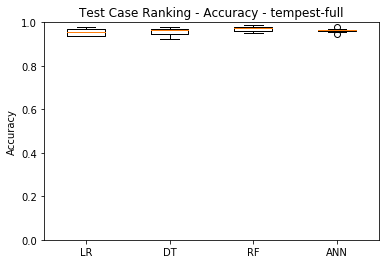

In [22]:
boxplots(accuracy, dataset='tempest-full', labels=labels_acc, title=titleAcc, ylabel=ylab_acc, save_file_name='Accuraccy', save=False)


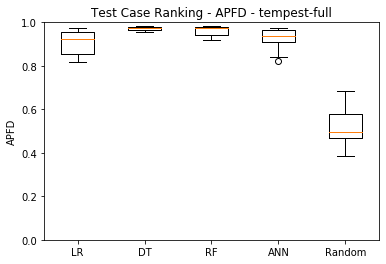

In [23]:
boxplots(apfds, dataset='tempest-full', labels=labels_APFD, title=titleAPFD, ylabel=ylab_apfd,save_file_name='APFD', save=False)